In [1]:
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.WARN)
import ray
ray.init(log_to_driver=False)
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.random_circuit import random_circuits
from janusq.data_objects.backend import FullyConnectedBackend

from janusq.simulator.noisy_simulator import NoisySimulator
import random

from janusq.tools.ray_func import map

2024-04-25 05:32:38,347	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67092480 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-04-25 05:32:38,486	INFO worker.py:1724 -- Started a local Ray instance.


# Noise Optimization Based on JanusQ-CT


**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

The accurate fidelity prediction enables JanusQ-CT to guide the noise optimization. In this notebook, we introduce the optimization strategies.

In [2]:
# build a simulator

n_qubits = 5
n_steps = 1
n_walks = 20
backend = FullyConnectedBackend(n_qubits)

circuits = random_circuits(backend, n_circuits=50, n_gate_list=list(range(10, 150, 10)), two_qubit_prob_list=[0.3, 0.4, 0.6], reverse=True)
up_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
up_model.train(circuits, multi_process=False, remove_redundancy = False)

all_paths = up_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = up_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

100%|██████████| 84/84 [00:00<00:00, 87.44it/s] 


In [3]:
# train a fidelity model
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=False)

fidelity_model = FidelityModel(up_model)
fidelity_model.train((circuits, ground_truth_fidelities))

67it [00:00, 390846.13it/s]
17it [00:00, 151708.87it/s]


In [4]:
# generate a set of benchmarking circuits

from janusq.data_objects.algorithms import get_algorithm_circuits
from janusq.optimizations.scheduling.scheduling_ct import Scheduler
from janusq.optimizations.mapping.mapping_ct import Mapper
algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'grover']
benchmarking_circuits = get_algorithm_circuits(n_qubits, backend, algs)

## Scheduling

We can use Janus-CT to guide the scheduling.

In [5]:
scheduler = Scheduler(fidelity_model)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = scheduler.run(circuit, timeout=60)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before scheduling: ', baseline_fidelities[-1], 'after scheduling: ', opt_fidelities[-1])

before scheduling:  0.9720016931385862 after scheduling:  0.9565717686009497
before scheduling:  0.9825412098329267 after scheduling:  0.9834544400767603


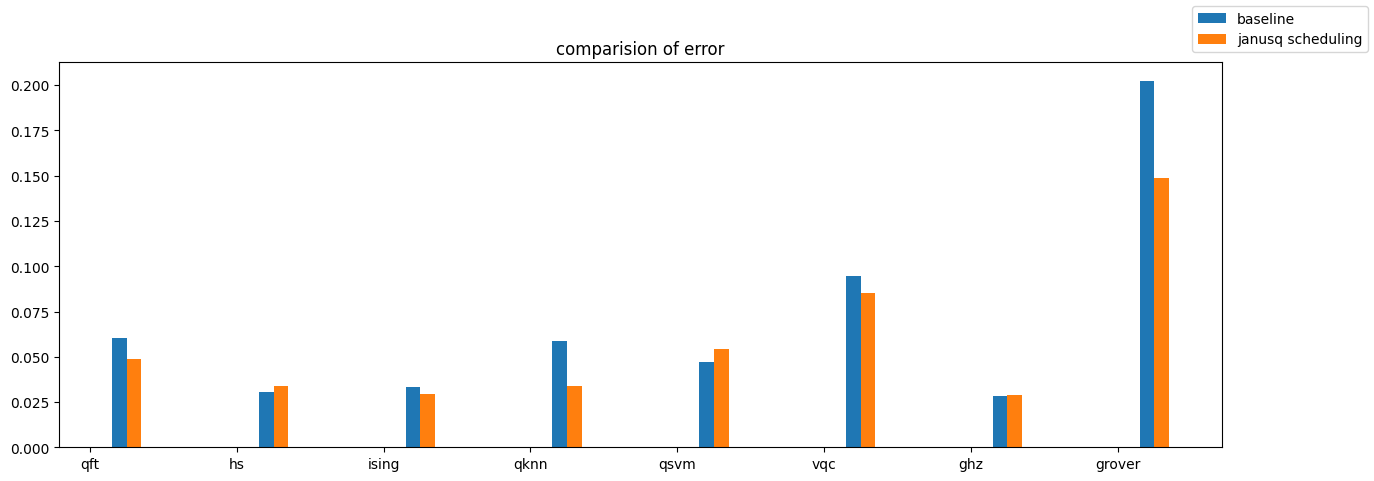

*** SIGTERM received at time=1713661863 on cpu 6 ***
PC: @     0x2aaaab548e2e  (unknown)  (unknown)
    @     0x2aaaab465520  (unknown)  (unknown)
[2024-04-21 01:11:03,492 E 6552 6552] logging.cc:361: *** SIGTERM received at time=1713661863 on cpu 6 ***
[2024-04-21 01:11:03,538 E 6552 6552] logging.cc:361: PC: @     0x2aaaab548e2e  (unknown)  (unknown)
[2024-04-21 01:11:03,580 E 6552 6552] logging.cc:361:     @     0x2aaaab465520  (unknown)  (unknown)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,1-baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,1-opt_fidelities,width =2,label='janusq scheduling')

plt.title('comparision of error')
axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()